# Weighted Portfolio

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
weights = {'^GSPC': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}
symbols = list(weights.keys())
directions = {'^GSPC': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)
ts

,^GSPC_high,^GSPC_low,^GSPC_close,TLT_high,TLT_low,TLT_close,GLD_high,GLD_low,GLD_close,TLT_SHRT_high,TLT_SHRT_low,TLT_SHRT_close
date,,,,,,,,,,,,
1927-12-30,17.66,17.66,17.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-03,17.76,17.76,17.76,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-04,17.72,17.72,17.72,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-05,17.55,17.55,17.55,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-06,17.66,17.66,17.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-17,3233.52,3205.65,3224.73,167.40,166.47,166.78,170.27,169.61,170.12,167.40,166.47,166.78
2020-07-20,3258.61,3215.16,3251.84,167.62,166.80,167.19,171.07,170.27,170.94,167.62,166.80,167.19
2020-07-21,3277.29,3247.77,3257.30,167.72,167.08,167.29,173.25,172.31,173.00,167.72,167.08,167.29


In [5]:
# add calendar columns
ts = portfolio.calendar(ts)

In [6]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [7]:
portfolio.init_trade_logs(ts, capital, margin=2)
pf.TradeLog.instance

{'^GSPC': <pinkfish.trade.TradeLog at 0x7f07479cb880>,
 'TLT': <pinkfish.trade.TradeLog at 0x7f07479cb8b0>,
 'GLD': <pinkfish.trade.TradeLog at 0x7f07479cb5b0>,
 'TLT_SHRT': <pinkfish.trade.TradeLog at 0x7f07479cb5e0>}

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio.symbols:
            price = portfolio.get_row_column_value(row, symbol)
            weight = 0 if end_flag else weights[symbol]
            direction = directions[symbol]
            portfolio.adjust_percent(date, price, weight, symbol, row, direction)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs()

In [10]:
rlog.head(10)

,date,seq_num,price,shares,entry_exit,direction,symbol
0,2004-12-01,0,1191.37,8,entry,LONG,^GSPC
1,2004-12-01,1,51.47,116,entry,LONG,TLT
2,2004-12-01,2,45.38,44,entry,LONG,GLD
3,2004-12-01,3,51.47,38,entry,SHRT,TLT_SHRT
4,2005-01-03,4,53.03,2,exit,LONG,TLT
5,2005-01-03,5,43.02,2,entry,LONG,GLD
6,2005-02-01,6,54.72,4,exit,LONG,TLT
7,2005-02-01,7,42.10,1,entry,LONG,GLD
8,2005-02-01,8,54.72,2,exit,SHRT,TLT_SHRT
9,2005-03-01,9,53.98,3,entry,LONG,TLT


In [11]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
351,2016-05-02,115.74,2020-04-01,166.41,50.67,253.37,5,35346.23,LONG,TLT
352,2016-05-02,115.74,2020-04-01,166.41,-50.67,-101.35,2,35244.89,SHRT,TLT_SHRT
353,2016-05-02,2081.43,2020-07-23,3275.96,1194.53,1194.53,1,36439.42,LONG,^GSPC
354,2016-06-01,115.94,2020-04-01,149.45,33.51,100.53,3,36539.95,LONG,GLD
355,2016-06-01,115.94,2020-07-23,177.22,61.28,61.28,1,36601.23,LONG,GLD
...,...,...,...,...,...,...,...,...,...,...
446,2020-06-01,162.09,2020-07-23,169.00,6.91,138.20,20,51617.78,LONG,TLT
447,2020-06-01,163.66,2020-07-23,177.22,13.56,40.68,3,51658.46,LONG,GLD
448,2020-06-01,162.09,2020-07-23,169.00,-6.91,-41.46,6,51617.00,SHRT,TLT_SHRT
449,2020-07-01,163.42,2020-07-23,169.00,5.58,22.32,4,51639.32,LONG,TLT


In [12]:
dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2020-07-17,59912.42,59912.42,59912.42,366,-50264.44,1.84,-
2020-07-20,60513.56,60513.56,60513.56,366,-50264.44,1.83,-
2020-07-21,60765.92,60765.92,60765.92,366,-50264.44,1.83,-
2020-07-22,61351.72,61351.72,61351.72,366,-50264.44,1.82,-
2020-07-23,61628.16,61628.16,61628.16,0,61628.16,1.00,X


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2020-07-23
beginning_balance                                           10000
ending_balance                                           61628.16
total_net_profit                                         51628.16
gross_profit                                             59593.96
gross_loss                                               -7965.80
profit_factor                                                7.48
return_on_initial_capital                                  516.28
annual_return_rate                                          12.30
trading_period                           15 years 8 months 5 days
pct_time_in_market                                          99.80
margin                                                          2
avg_leverage                                                 1.89
max_leverage                                                 2.15
min_levera

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

2004-11-18 00:00:00 BUY  115 SPY @ 86.59
2020-07-23 00:00:00 SELL 115 SPY @ 326.33


In [15]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

In [16]:
benchmark.stats = benchmark.get_stats()

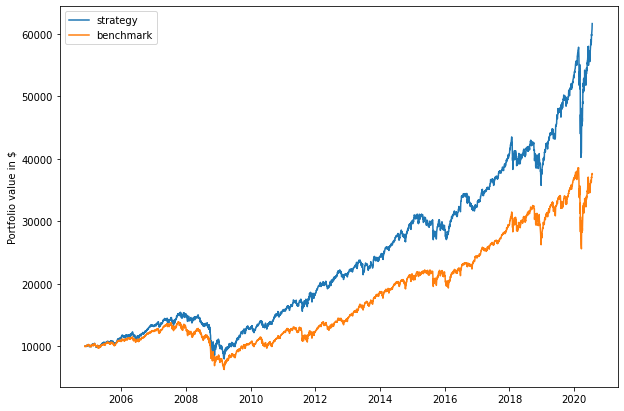

In [17]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

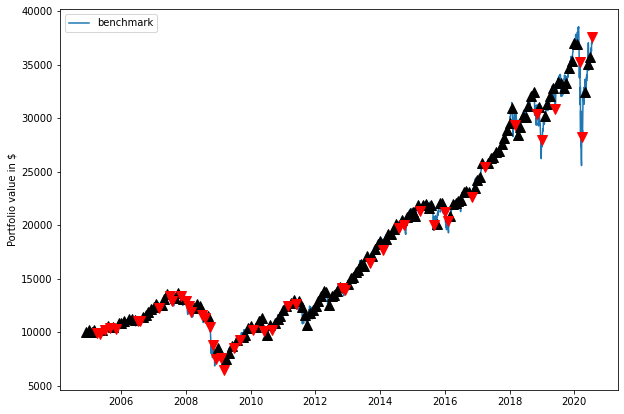

In [18]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [19]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$61,628.16","$37,569.69"
total_net_profit,"$51,628.16","$27,569.69"
gross_profit,"$59,593.96","$27,569.69"
gross_loss,"-$7,965.80",$0.00


,strategy,benchmark
annual_return_rate,12.30,8.81
max_closed_out_drawdown,-48.42,-55.02
drawdown_annualized_return,-3.94,-6.25
drawdown_recovery,-1.36,-1.42
best_month,29.50,23.46
worst_month,-30.49,-30.95
sharpe_ratio,0.75,0.53
sortino_ratio,0.92,0.63
monthly_std,4.37,4.57


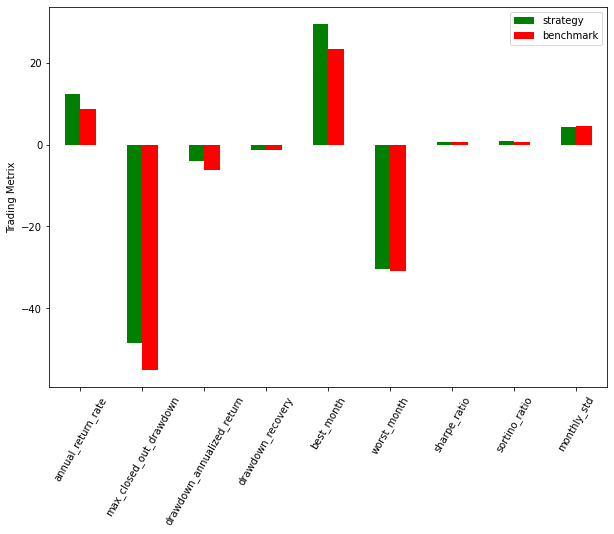

In [20]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df